In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import pandas as pd
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import json
#%matplotlib inline


#uploaded = files.upload()
#import io 
#df= pd.read_csv(io.BytesIO(uploaded['Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv']))
#df= pd.read_csv('ZeroBias_2017UL_DataFrame_ChargeInnerLayer4.txt')
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv')
df['histo']=df['histo'].apply(literal_eval)

df.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df.sort_index(inplace=True)
print(df['histo'].shape)
print(df.tail())
print(df.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
(225954,)
                  Unnamed: 0  ...                                              histo
fromrun fromlumi              ...                                                   
306462  95             67823  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        96             67824  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        97             67825  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        98             67826 

In [3]:
import seaborn as sns
from pylab import rcParams
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
import tensorflow
#from tensorflow import set_random_seed
tensorflow.random.set_seed(2)
#set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
DATA_SPLIT_PCT_VALID = 0.1
rcParams['figure.figsize'] = 10, 8




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
#add Golden JSON labels to the DF
import json

def checkLS(run,ls):
    isok=False
    global jsondata

    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok=True
                return isok
        return   isok

#load the golden json file
jsondata={}
with open('/content/drive/My Drive/Colab Notebooks/GoldenJSON17.json') as json_file:
    jsondata = json.load(json_file)

df['labels']=False #initialize to false

for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:
        df['labels'][run][ls]=checkLS(run,ls)

'''
def checkLSAnomaly(run,ls):
    isok_anomaly=True
    global jsondata
    
    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok_anomaly=False
                return isok_anomaly
        return isok_anomaly


df['anomaly']=True #initialize
for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:  
        df['anomaly'][run][ls]=checkLSAnomaly(run,ls)
'''
#fname_bad = 'BAD_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.txt'
#fname_gold = 'GOLDEN_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv'
#df[df['labels']!=True].to_csv(fname_bad)
#df[df['labels']==True].to_csv(fname_gold)

#print(df[df['labels']!=True]) #to check against the Golden JSON
print(df[df['labels']==False].shape)
print(df[df['labels']==True].shape)
#print(df[df['anomaly']==True].shape)
#print(df[df['anomaly']==False].shape)
#print(df[df['anomaly']==False])
#print(df[df['anomaly']==True])
#print(df.shape)
#print(df['labels'])
#print(df['anomaly'])

df['type']=df['labels']
df['type']=df['type'].apply(lambda x:0 if x== True else 1)
df[df['type']==0]


(23655, 11)
(202299, 11)


Unnamed: 0  fromrun  ...  labels type
fromrun fromlumi                       ...             
297050  12              4535   297050  ...    True    0
        13              4536   297050  ...    True    0
        14             15690   297050  ...    True    0
        15             15691   297050  ...    True    0
        16              4537   297050  ...    True    0
...                      ...      ...  ...     ...  ...
306460  60             62547   306460  ...    True    0
        61             62548   306460  ...    True    0
        62             62549   306460  ...    True    0
        63             62550   306460  ...    True    0
        64             62551   306460  ...    True    0

[202299 rows x 12 columns]

In [0]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT_VALID, random_state=SEED)

X_train_true = np.stack(df_train['histo'][df_train['labels']==True].values, axis=0)
X_train_false = np.stack(df_train['histo'][df_train['labels']==False].values, axis=0)

X_valid_true = np.stack(df_valid['histo'][df_valid['labels']==True].values, axis=0)
X_valid_false = np.stack(df_valid['histo'][df_valid['labels']==False].values, axis=0)


X_test_true = np.stack(df_test['histo'][df_test['labels']==True].values, axis=0)
X_test_false = np.stack(df_test['histo'][df_test['labels']==False].values, axis=0)

from sklearn.preprocessing import normalize

X_train_true_norm=normalize(X_train_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_train_false_norm=normalize(X_train_false, norm='l1', axis=1)

X_valid_true_norm=normalize(X_valid_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_valid_false_norm=normalize(X_valid_false, norm='l1', axis=1)

X_test_true_norm=normalize(X_test_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test_false_norm=normalize(X_test_false, norm='l1', axis=1)




In [0]:
from sklearn import decomposition
import scipy

from keras.layers import Input, Dense, Layer, InputSpec
from keras import regularizers, activations, initializers, constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

class DenseTied(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [13]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

nb_epoch = 100
batch_size = 500
input_dim = X_train_true_norm.shape[1] #num of predictor variables, 
encoding_dim = 10
#hidden_dim = int(encoding_dim / 2)
hidden_dim = 3
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", use_bias = True)(input_layer)  #, activity_regularizer=regularizers.l1(learning_rate))(input_layer)
#encoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(hidden_dim, activation="tanh" )(encoder)
decoder = DenseTied(encoding_dim, activation="tanh", tied_to=encoder, use_bias = True)(decoder)
decoder = Dense(input_dim, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

AttributeError: ignored

In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss=mseTop10,
                    optimizer='adam')
'''
cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
'''
history = autoencoder.fit(X_train_true_norm, X_train_true_norm,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_valid_true_norm, X_valid_true_norm),
                    verbose=1).history

Train on 145591 samples, validate on 16212 samples
Epoch 1/100
145591/145591 [==============================] - 3s 24us/step - loss: 1.5581e-04 - accuracy: 0.1266 - val_loss: 2.3014e-05 - val_accuracy: 0.2811
Epoch 2/100
145591/145591 [==============================] - 2s 11us/step - loss: 1.3108e-05 - accuracy: 0.3602 - val_loss: 5.5013e-06 - val_accuracy: 0.4157
Epoch 3/100
145591/145591 [==============================] - 2s 11us/step - loss: 5.0521e-06 - accuracy: 0.4350 - val_loss: 4.3586e-06 - val_accuracy: 0.4397
Epoch 4/100
145591/145591 [==============================] - 2s 10us/step - loss: 4.4819e-06 - accuracy: 0.4392 - val_loss: 3.9916e-06 - val_accuracy: 0.4386
Epoch 5/100
145591/145591 [==============================] - 1s 10us/step - loss: 4.0401e-06 - accuracy: 0.4353 - val_loss: 3.4362e-06 - val_accuracy: 0.4358
Epoch 6/100
145591/145591 [==============================] - 2s 12us/step - loss: 3.3160e-06 - accuracy: 0.4347 - val_loss: 2.7047e-06 - val_accuracy: 0.4409
E

In [0]:
print(history)

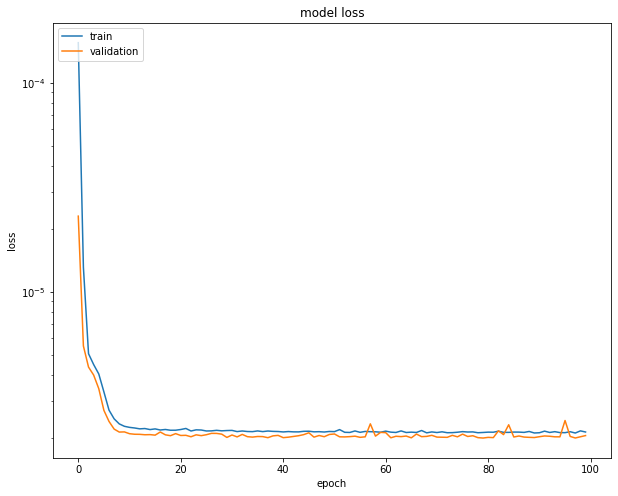

In [12]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

# "Loss"
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale("log")
#plt.xlim(0,100)
plt.show()

#plot_loss(history, "Original model loss")

In [0]:
X_train_all = np.stack(df_train['histo'].values, axis=0)
X_train_all_norm=normalize(X_train_all, norm='l1', axis=1)

train_x_predictions = autoencoder.predict(X_train_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_train=K.eval(mseTop10(X_train_all_norm, train_x_predictions))
#mse_train=np.mean(np.power(X_train_all_norm - train_x_predictions, 2), axis=1)
print(mse_train)
error_df_train = pd.DataFrame({'reconstruction_error': mse_train,
                        'true_class': df_train['type']})
error_df_train.describe()


[1.94431606e-06 6.88958411e-07 1.48267879e-06 ... 8.64681115e-07
 6.24569208e-04 2.98100808e-06]


,reconstruction_error,true_class
count,1.626860e+05,162686.000000
mean,3.103604e-05,0.105080
std,1.355866e-04,0.306657
min,1.147530e-07,0.000000
25%,9.254079e-07,0.000000
50%,1.671812e-06,0.000000
75%,2.489426e-06,0.000000
max,8.436200e-03,1.000000


In [0]:
X_test_all = np.stack(df_test['histo'].values, axis=0)
X_test_all_norm=normalize(X_test_all, norm='l1', axis=1)

test_x_predictions = autoencoder.predict(X_test_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_test=K.eval(mseTop10(X_test_all_norm, test_x_predictions))
#mse_test=np.mean(np.power(X_test_all_norm - test_x_predictions, 2), axis=1)
print(mse_test)
error_df_test = pd.DataFrame({'reconstruction_error': mse_test,
                        'true_class': df_test['type']})
error_df_test.describe()


[5.22355385e-06 9.71233425e-07 5.58337620e-07 ... 3.84075472e-06
 1.48324820e-06 2.99101298e-06]


,reconstruction_error,true_class
count,4.519100e+04,45191.000000
mean,3.066883e-05,0.103892
std,1.325134e-04,0.305124
min,1.500204e-07,0.000000
25%,9.334523e-07,0.000000
50%,1.681180e-06,0.000000
75%,2.499644e-06,0.000000
max,3.860152e-03,1.000000


In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
#mse_valid=np.mean(np.power(X_valid_all_norm - valid_x_predictions, 2), axis=1)
print(mse_valid)
error_df_valid = pd.DataFrame({'reconstruction_error': mse_valid,
                        'true_class': df_valid['type']})
error_df_valid.describe()



[2.31879481e-06 4.24176781e-07 1.64413916e-06 ... 1.64642459e-06
 1.70281077e-06 1.18368336e-06]


,reconstruction_error,true_class
count,1.807700e+04,18077.000000
mean,3.094331e-05,0.103170
std,1.301256e-04,0.304189
min,1.666492e-07,0.000000
25%,9.366187e-07,0.000000
50%,1.686855e-06,0.000000
75%,2.496882e-06,0.000000
max,1.829121e-03,1.000000


In [0]:
X_all = np.stack(df['histo'].values, axis=0)
X_all_good = np.stack(df['histo'][df['labels']==True].values, axis=0)
X_all_bad = np.stack(df['histo'][df['labels']==False].values, axis=0)
X_all_norm=normalize(X_all, norm='l1', axis=1)
X_all_good_norm=normalize(X_all_good, norm='l1', axis=1)
X_all_bad_norm=normalize(X_all_bad, norm='l1', axis=1)

x_predictions = autoencoder.predict(X_all_norm)
x_good_predictions = autoencoder.predict(X_all_good_norm)
x_bad_predictions = autoencoder.predict(X_all_bad_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_all=K.eval(mseTop10(X_all_norm, x_predictions))
mse_good_all=K.eval(mseTop10(X_all_good_norm, x_good_predictions))
mse_bad_all=K.eval(mseTop10(X_all_bad_norm, x_bad_predictions))
#mse_test=np.mean(np.power(X_test_all_norm - test_x_predictions, 2), axis=1)
print(mse_all)
error_df_all = pd.DataFrame({'reconstruction_error': mse_all,
                        'true_class': df['type']})
error_df_all.describe()


[2.13207350e-06 1.23987067e-06 1.91045360e-06 ... 6.24569245e-04
 6.24569245e-04 6.24569245e-04]


,reconstruction_error,true_class
count,2.259540e+05,225954.000000
mean,3.095518e-05,0.104689
std,1.345464e-04,0.306154
min,1.147530e-07,0.000000
25%,9.277631e-07,0.000000
50%,1.674930e-06,0.000000
75%,2.492138e-06,0.000000
max,8.436200e-03,1.000000


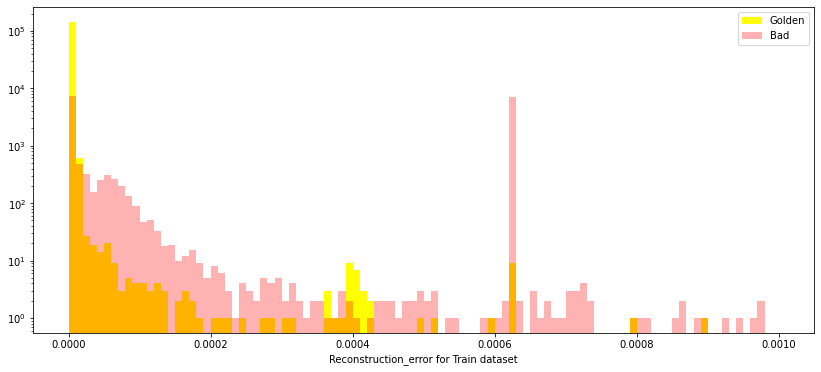

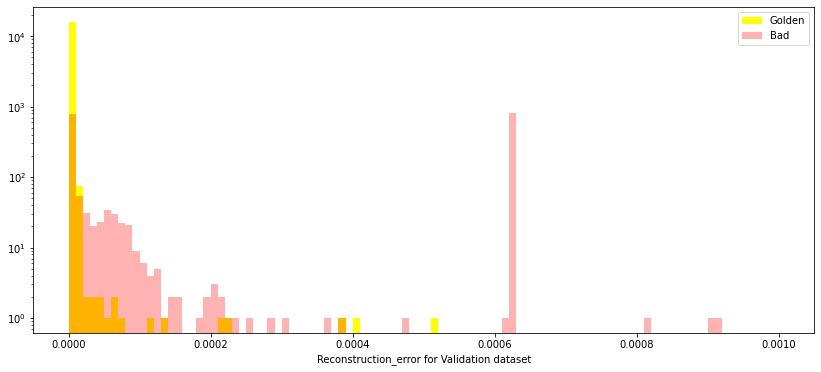

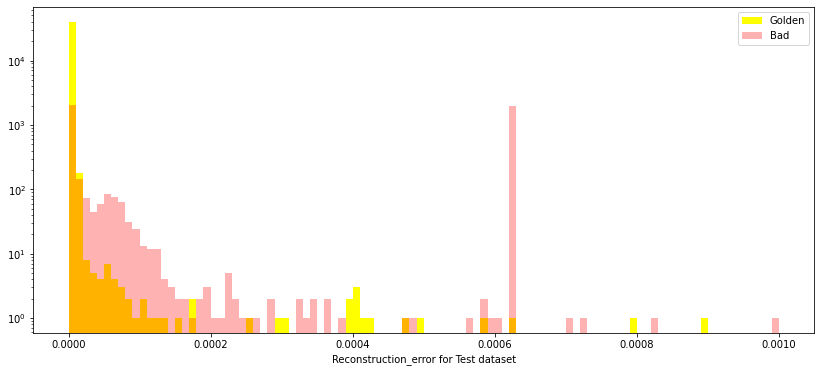

In [0]:

rcParams['figure.figsize'] = 14, 6
'''
# reconstruction error for the normal transactions in the testing dataset
fig = plt.figure(1)
ax = fig.add_subplot(111)
Anomaly_error_df_valid = error_df_valid[(error_df_valid['true_class']== True)]
Golden_error_df_valid = error_df_valid[(error_df_valid['true_class']== False)]
ax.hist(Golden_error_df_valid.reconstruction_error.values, bins=1000, range=(0., 0.0002), color = 'yellow', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_valid.reconstruction_error.values, bins=1000, range=(0., 0.0002), color = 'red', ls='dashed',  alpha = 0.3, lw=3, log=True)
#ax.set_alpha(0.9)
plt.show()
'''
# reconstruction error for the normal transactions in the testing dataset
#rcParams['figure.figsize'] = 10, 8
Anomaly_error_df_train = error_df_train[(error_df_train['true_class']== True)]
Golden_error_df_train = error_df_train[(error_df_train['true_class']== False)]
Anomaly_error_df_valid = error_df_valid[(error_df_valid['true_class']== True)]
Golden_error_df_valid = error_df_valid[(error_df_valid['true_class']== False)]
Anomaly_error_df_test = error_df_test[(error_df_test['true_class']== True)]
Golden_error_df_test = error_df_test[(error_df_test['true_class']== False)]
fig = plt.figure(1)
#ax = fig.add_subplot(131)
ax = fig.add_subplot()
ax.hist(Golden_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Train : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_train.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Train : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Train dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
fig = plt.figure(2)
#ax = fig.add_subplot(132)
ax = fig.add_subplot()
ax.hist(Golden_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'validation : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_valid.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Validation : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Validation dataset')
plt.legend(['Golden', 'Bad'], loc='upper right')
fig = plt.figure(3)
#ax = fig.add_subplot(133)
ax = fig.add_subplot()
ax.hist(Golden_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'yellow', label= 'Test : Golden', ls='dashed',  alpha = 1.0, lw=3, log=True)
ax.hist(Anomaly_error_df_test.reconstruction_error.values, bins=100, range=(0., 0.0010), color = 'red', label= 'Test : Bad', ls='dashed',  alpha = 0.3, lw=3, log=True)
ax.set_xlabel('Reconstruction_error for Test dataset')
#ax.set_alpha(0.9)
#plt.tight_layout()
plt.legend(['Golden', 'Bad'], loc='upper right')
plt.show()



[0.00000000e+00 6.86855644e-06 6.86855644e-06 ... 9.99711521e-01
 9.99711521e-01 1.00000000e+00]
[0.         0.         0.00274934 ... 0.9999415  1.         1.        ]
[1.00843620e+00 8.43619960e-03 9.25042935e-04 ... 1.73656484e-07
 1.72487138e-07 1.14752979e-07]
Best Threshold=0.000004, G-Mean=0.757
[0.         0.         0.         ... 0.99944486 0.99944486 1.        ]
[0.00000000e+00 5.36193029e-04 2.68096515e-03 ... 9.99463807e-01
 1.00000000e+00 1.00000000e+00]
[1.00182912e+00 1.82912080e-03 8.14818349e-04 ... 1.96687366e-07
 1.95846605e-07 1.66649224e-07]
Best Threshold=0.000004, G-Mean=0.764
[0.         0.         0.         ... 0.99829613 0.99829613 1.        ]
[0.00000000e+00 2.12992545e-04 1.27795527e-03 ... 9.99787007e-01
 1.00000000e+00 1.00000000e+00]
[1.00386015e+00 3.86015203e-03 9.97988329e-04 ... 2.20128955e-07
 2.20078104e-07 1.50020365e-07]
Best Threshold=0.000004, G-Mean=0.755


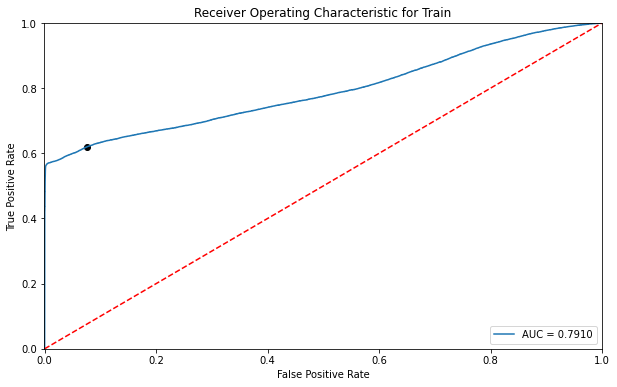

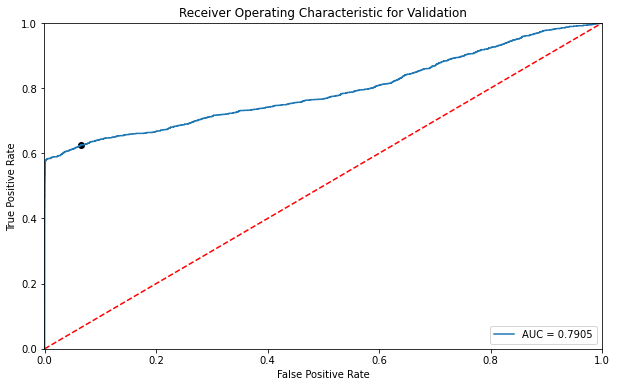

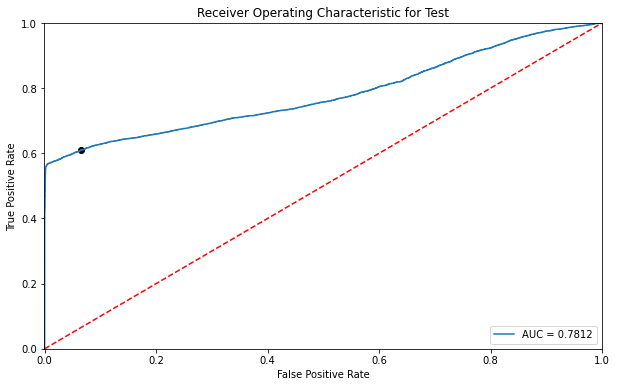

In [0]:
rcParams['figure.figsize'] = 10, 6
#ROC for Train
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_train.true_class, error_df_train.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(1)
#plt.subplot(1,3,1)
plt.title('Receiver Operating Characteristic for Train')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();


#ROC for Validation
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(2)
#plt.subplot(1,3,2)
plt.title('Receiver Operating Characteristic for Validation')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show();

# ROC for test
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df_test.true_class, error_df_test.reconstruction_error)
print(fpr)
print(tpr)
print(thresholds)
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
fig = plt.figure(3)
#plt.subplot(1,3,3)
plt.title('Receiver Operating Characteristic for Test')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Best Threshold=0.000013, F-Score=0.709


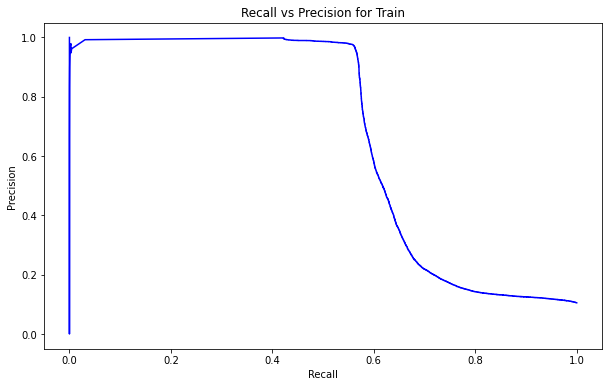

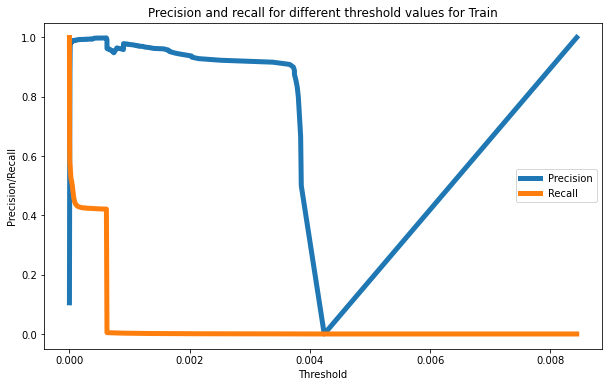

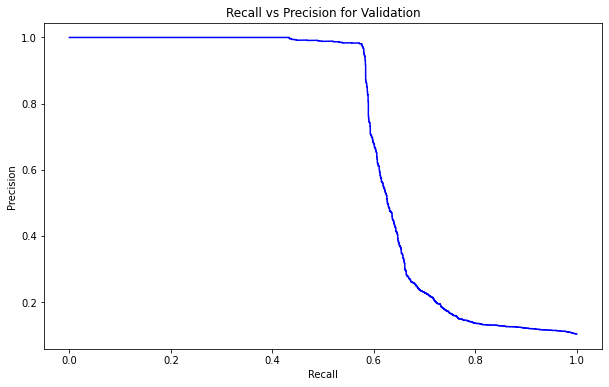

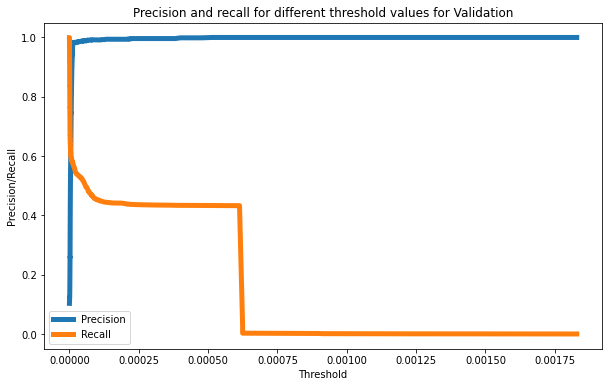

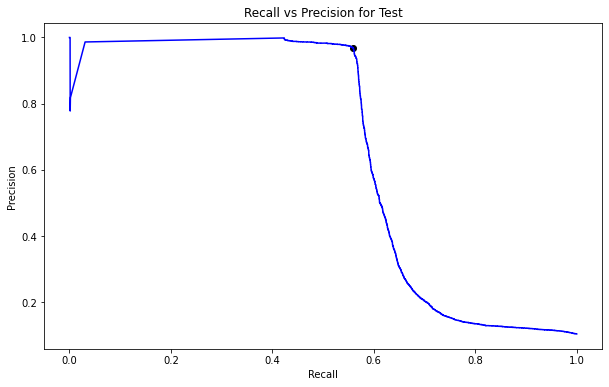

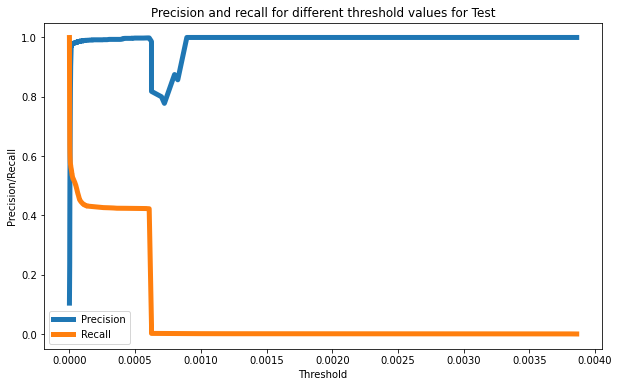

In [0]:
rcParams['figure.figsize'] = 10, 6
from numpy import argmax
#P-R curve for train
precision, recall, th = precision_recall_curve(error_df_train.true_class, error_df_train.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = argmax(fscore)
#print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.figure(1)
#plt.subplot(2,3,1)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Train')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(2)
#plt.subplot(2,3,4)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Train')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()



#P-R curve for validation
precision, recall, th = precision_recall_curve(error_df_valid.true_class, error_df_valid.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
#ix = argmax(fscore)
#print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.figure(3)
#plt.subplot(2,3,2)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(4)
#plt.subplot(2,3,5)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Validation')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()


#P-R curve for test
precision, recall, th = precision_recall_curve(error_df_test.true_class, error_df_test.reconstruction_error)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f1 score
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ix = argmax(fscore)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
plt.figure(5)
#plt.subplot(2,3,3)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.title('Recall vs Precision for Test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure(6)
#plt.subplot(2,3,6)
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values for Test')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

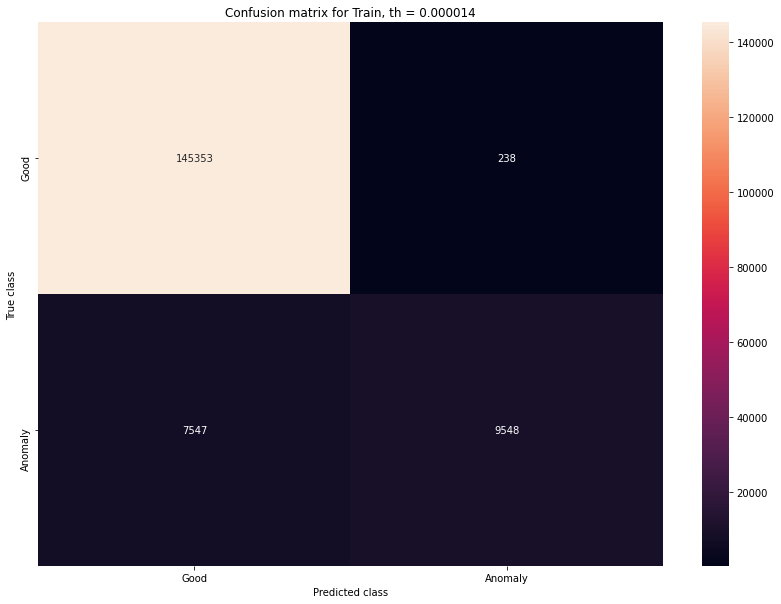

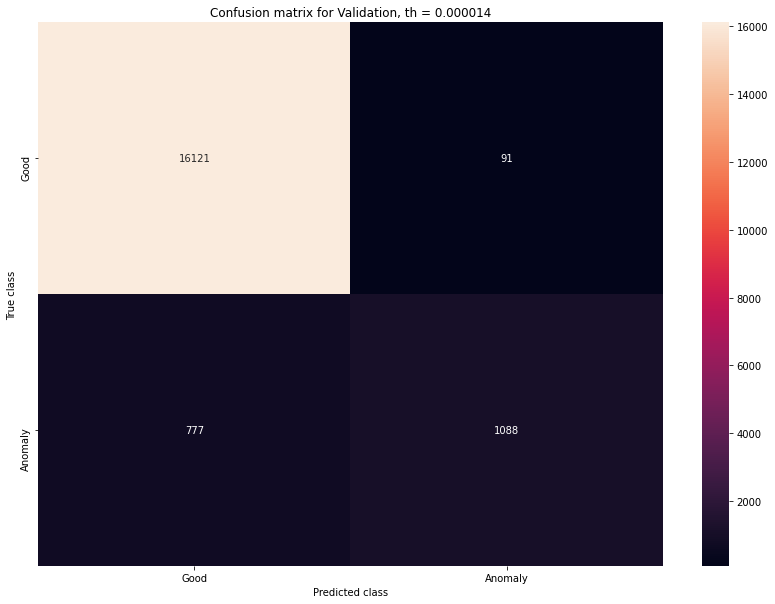

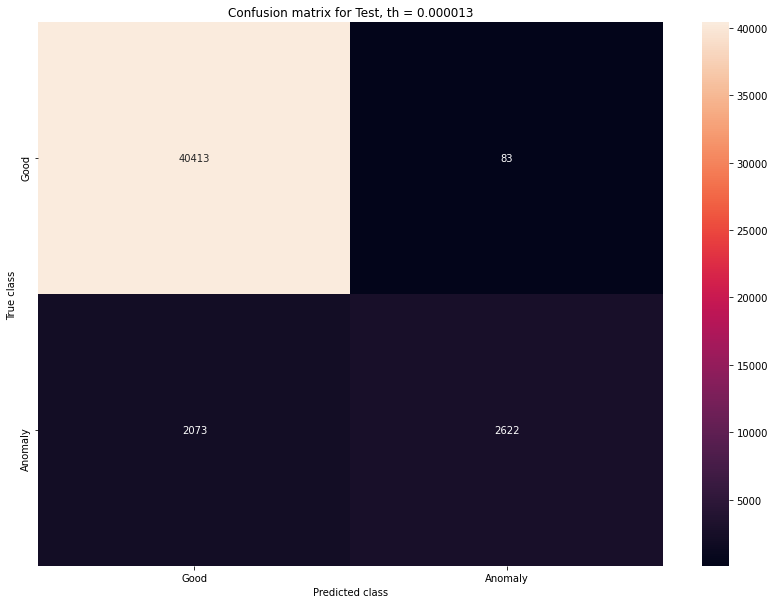

In [0]:
rcParams['figure.figsize'] = 14, 10
#confusion matrix for train
import seaborn as sns
threshold_train = 0.000014
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_train else 0 for e in error_df_train.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_train.true_class, y_pred)
plt.figure(1)
#plt.subplot(1,3,1)
#plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Train, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()

#confusion matrix for validation
#import seaborn as sns
threshold_valid = 0.000010
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold_valid else 0 for e in error_df_valid.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_valid.true_class, y_pred)
#plt.figure(figsize=(12, 12))
#plt.subplot(1,3,2)
plt.figure(2)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Validation, th = 0.000014")
plt.ylabel('True class')
plt.xlabel('Predicted class')
#plt.show()

#confusion matrix for test
#import seaborn as sns
threshold = 0.000013
LABELS = ['Good', 'Anomaly']
y_pred = [1 if e > threshold else 0 for e in error_df_test.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.true_class, y_pred)
#plt.figure(figsize=(12, 12))
plt.figure(3)
#plt.subplot(1,3,3)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for Test, th = 0.000013")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

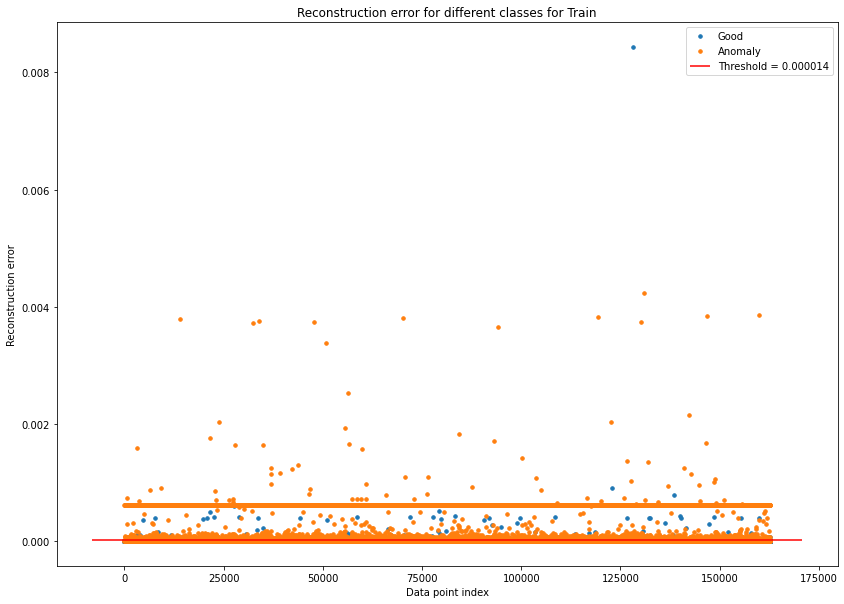

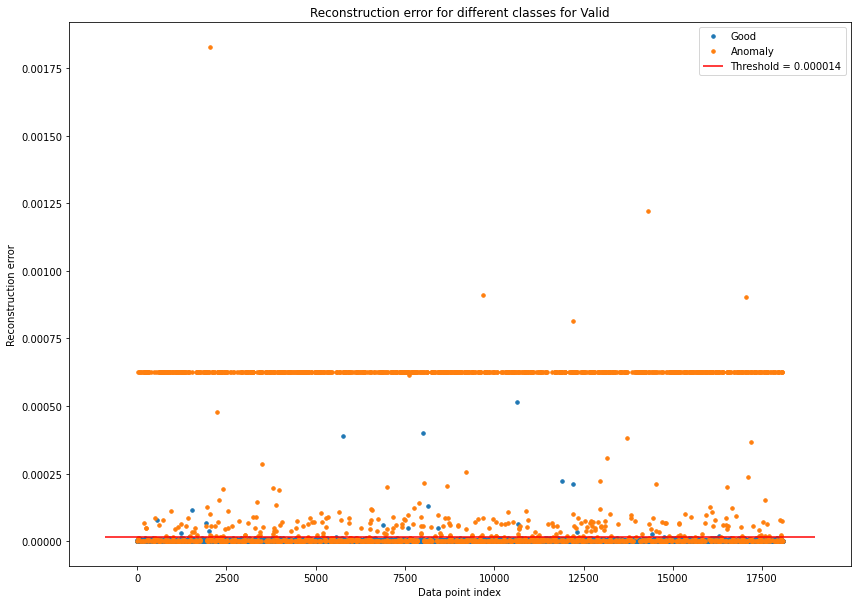

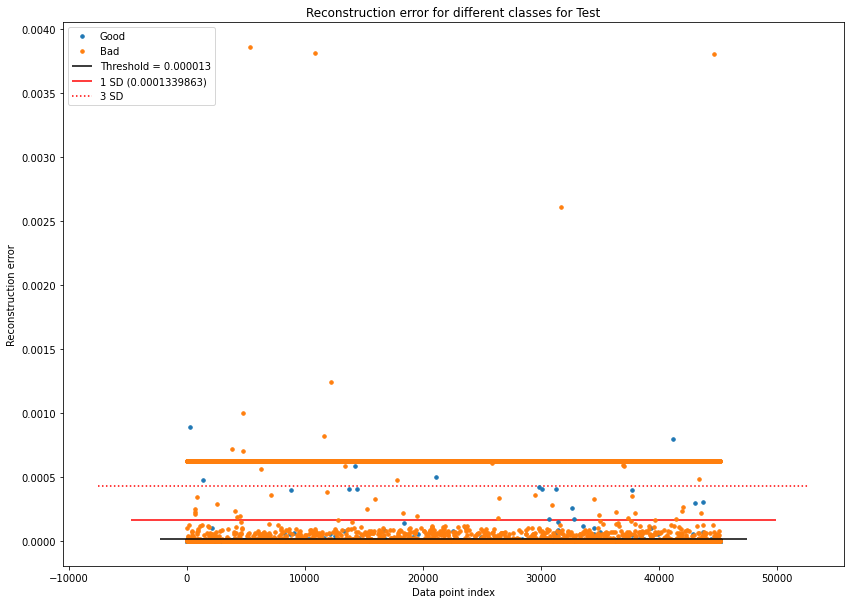

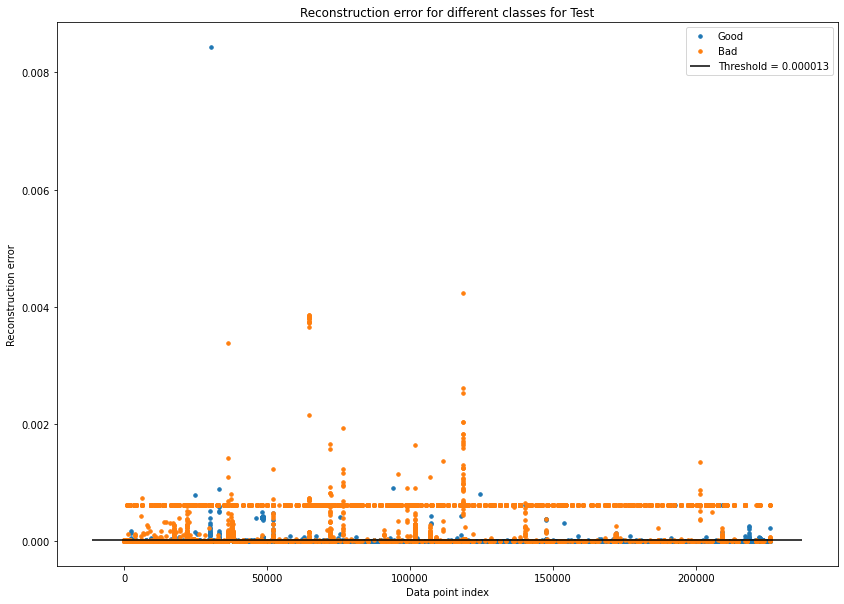

In [0]:
rcParams['figure.figsize'] = 14, 10
#Scatter plot for Train
error_df_train = error_df_train.reset_index(drop=True)
threshold_fixed_train = 0.000014
groups = error_df_train.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_train, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Train")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();

#Scatter plot for Validation
error_df_valid = error_df_valid.reset_index(drop=True)
threshold_fixed_valid = 0.000014
groups = error_df_valid.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Anomaly" if name == 1 else "Good")
ax.hlines(threshold_fixed_valid, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold = 0.000014')
ax.legend()
plt.title("Reconstruction error for different classes for Valid")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
#plt.show();


error_df_test = error_df_test.reset_index(drop=True)
threshold_fixed_test = 0.000013
groups = error_df_test.groupby('true_class')
gmean= 3.100298e-05 
gstd = 1.339863e-04
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Bad" if name == 1 else "Good")
ax.hlines(threshold_fixed_test, ax.get_xlim()[0], ax.get_xlim()[1], colors="k", zorder=100, label='Threshold = 0.000013')
#ax.hlines(gmean, ax.get_xlim()[0], ax.get_xlim()[1], color="blue", label="Run average: " + str(gmean))
ax.hlines(gmean+(1.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='1 SD (' + str(gstd) + ")")
ax.hlines(gmean+(3.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='3 SD', linestyle=':')    
ax.legend()
plt.title("Reconstruction error for different classes for Test")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

error_df_all = error_df_all.reset_index(drop=True)
threshold_fixed_all = 0.000013
groups = error_df_all.groupby('true_class')
#gmean= 3.100298e-05 
#gstd = 1.339863e-04
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='', 
            label= "Bad" if name == 1 else "Good")
ax.hlines(threshold_fixed_all, ax.get_xlim()[0], ax.get_xlim()[1], colors="k", zorder=100, label='Threshold = 0.000013')
#ax.hlines(gmean, ax.get_xlim()[0], ax.get_xlim()[1], color="blue", label="Run average: " + str(gmean))
#ax.hlines(gmean+(1.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='1 SD (' + str(gstd) + ")")
#ax.hlines(gmean+(3.0*gstd), ax.get_xlim()[0], ax.get_xlim()[1], color="red", label='3 SD', linestyle=':')    
ax.legend()
#plt.scatter(df['fromrun'].unique(), y, marker='+', label='Data points')
plt.title("Reconstruction error for different classes for Test")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


In [0]:
df['mse2']=mse_all
df['mse2'].loc[df['labels']==True]=mse_good_all
df['mse2'].loc[df['labels']==False]=mse_bad_all
def globalMSETrend(df):
    
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in df['fromrun'].unique():
        #if (type==1): val=(df['mse'][run]).mean()
        val=(df['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="blue", label="Run average: " + str(gmean))
    plt.hlines(gmean+(1.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='1 SD (' + str(gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.ylim(rmin*0.9,rmax*1.1)
    plt.scatter(df['fromrun'].unique(), y, marker='+', label='Data points')
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend()
    plt.show()

In [0]:
def globalMSETrendAll(df):
    dff = df[df.labels==False]
    yf=[]
    #print (dff.head())
    rmax=0
    rmin=10
    
    #print(rmax, rmin)
    for run in dff['fromrun'].unique():
        #if (type==1): val=(dff['mse'][run]).mean()
        val=(dff['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        yf.append(val)
    
    arrayf=np.array(yf)
    gmeanf=arrayf.mean()
    sizef=float(arrayf.size)
    gstdf=arrayf.std()
    print(sizef)
##################
    dft = df[df.labels==True]
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in dft['fromrun'].unique():
        #if (type==1): val=(dft['mse'][run]).mean()
        val=(dft['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
#######################

    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="blue", label="Good Run average: " + str(gmean))
    plt.hlines(gmean+(1.0*gstd), dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="red", label='1 SD (' + str(gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), dft['fromrun'].unique().min(), dft['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.hlines(gmeanf,dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label="Bad Run average: " + str(gmeanf))
    plt.hlines(gmeanf+(1.0*gstd), dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label='1 SD (' + str(gstdf) + ")")
    plt.hlines(gmeanf+(3.0*gstd), dff['fromrun'].unique().min(), dff['fromrun'].unique().max(), color="green", label='3 SD', linestyle=':')
    
    
    plt.ylim(rmin*0.9,rmax*1.1)
    plt.scatter(dft['fromrun'].unique(), y, marker='+', label='Good Data points')
    plt.scatter(dff['fromrun'].unique(), yf, marker='+', label='Bad Data points',color="green")
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend()
    plt.show()
	


465.0
0 10
469.0


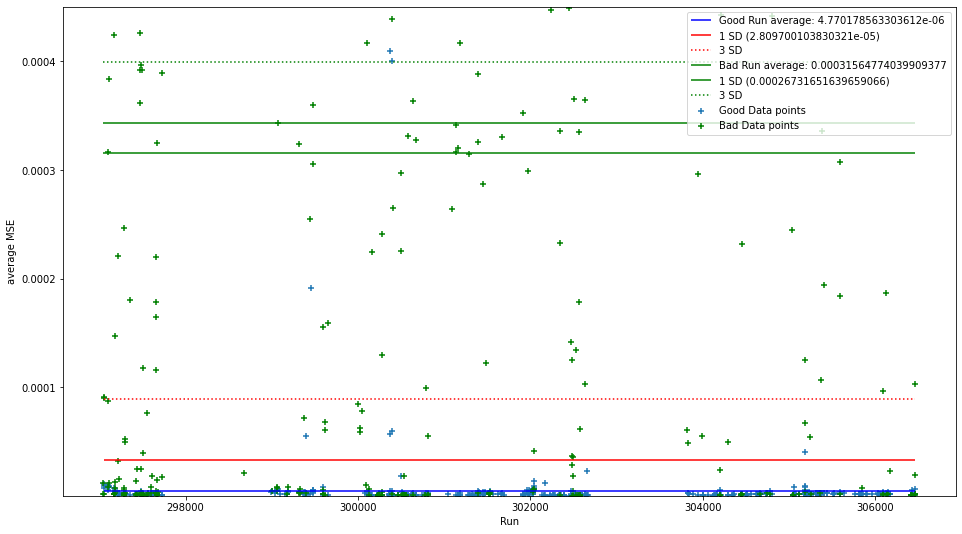

In [0]:
globalMSETrendAll(df)

In [0]:
print(X_train_true_norm.shape)
print(X_valid_true_norm.shape)
print(X_test_true_norm.shape)

NameError: ignored

In [0]:
#LSTM
from numpy import array
from keras.models import Sequential
from keras.models import Sequential
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers.advanced_activations import ReLU

lr = 0.0001
# reshape input into [samples, timesteps, features]
timesteps = len(X_train_true_norm[0])
n_samples = X_train_true_norm.shape[0]
n_features = 1
X_train_lstm = X_train_true_norm.reshape((n_samples, timesteps, 1))
print(X_train_lstm.shape)

timesteps_valid = len(X_valid_true_norm[0])
n_samples_valid = X_valid_true_norm.shape[0]
n_features = 1
X_valid_lstm = X_valid_true_norm.reshape((n_samples_valid, timesteps_valid, 1))

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(10, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(3, activation='tanh', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(3, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(10, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()



(129382, 100, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 10)           480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 168       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 3)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 3)            84        
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 10)           560       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            11        
Total params: 1,303
Trainable params: 1,303
Non-trainable params: 0
___________________________________

In [0]:
epochs=100
batch=500

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/lstm_logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_lstm, X_train_lstm, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_lstm, X_valid_lstm),
                                                verbose=2).history

Train on 129382 samples, validate on 32421 samples
Epoch 1/100
 - 181s - loss: 2.1108e-04 - val_loss: 1.9895e-04
Epoch 2/100
 - 179s - loss: 1.1894e-04 - val_loss: 3.4616e-05
Epoch 3/100
 - 176s - loss: 3.1598e-05 - val_loss: 3.0539e-05
Epoch 4/100
 - 176s - loss: 3.0371e-05 - val_loss: 3.0077e-05
Epoch 5/100
 - 176s - loss: 3.0051e-05 - val_loss: 2.9879e-05
Epoch 6/100
 - 176s - loss: 2.9889e-05 - val_loss: 2.9773e-05
Epoch 7/100
 - 176s - loss: 2.9783e-05 - val_loss: 2.9677e-05
Epoch 8/100
 - 176s - loss: 2.9703e-05 - val_loss: 2.9597e-05
Epoch 9/100
 - 177s - loss: 2.9646e-05 - val_loss: 2.9574e-05
Epoch 10/100
 - 176s - loss: 2.9580e-05 - val_loss: 2.9474e-05
Epoch 11/100
 - 176s - loss: 2.9531e-05 - val_loss: 2.9466e-05
Epoch 12/100
 - 175s - loss: 2.9491e-05 - val_loss: 2.9440e-05
Epoch 13/100
 - 176s - loss: 2.9443e-05 - val_loss: 2.9337e-05
Epoch 14/100
 - 175s - loss: 2.9391e-05 - val_loss: 2.9306e-05
Epoch 15/100
 - 176s - loss: 2.9343e-05 - val_loss: 2.9234e-05
Epoch 16/100


In [0]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale("log")
plt.show()

NameError: ignored

In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
error_df = pd.DataFrame({'Reconstruction_error': mse_valid,
                        'True_class': df_valid['labels']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [0]:
0#extract test and train data and put in dataframes

#df_train=df.loc[df['labels']==True]
#df_test=df.loc[df['labels']==False]
X_trainCol = np.stack(df['histo'][df['labels']==True].values, axis=1) #convert list of array to a stack to feed the model
X_testCol = np.stack(df['histo'][df['labels']==False].values, axis=1)
X_trainS = np.stack(df['histo'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_testS = np.stack(df['histo'][df['labels']==False].values, axis=0)

print(X_trainCol.shape , X_trainS.shape)
print(X_trainCol)
print(X_trainS)

from sklearn.preprocessing import normalize

X_train=normalize(X_trainS, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test=normalize(X_testS, norm='l1', axis=1)
print(X_train)
                      
df['origin']=''
df['origin'].loc[df['labels']==True]=X_train.tolist()
df['origin'].loc[df['labels']==False]=X_test.tolist()
print(df.shape)
print(df.origin.shape)

(100, 202299) (202299, 100)
[[ 33  43  34 ...  11   6   0]
 [213 201 241 ...  43  47   2]
 [426 389 362 ...  74  62   1]
 ...
 [ 54  65  43 ...   0   2   0]
 [ 52  74  49 ...   0   0   0]
 [ 67  50  55 ...   0   0   0]]
[[ 33 213 426 ...  54  52  67]
 [ 43 201 389 ...  65  74  50]
 [ 34 241 362 ...  43  49  55]
 ...
 [ 11  43  74 ...   0   0   0]
 [  6  47  62 ...   2   0   0]
 [  0   2   1 ...   0   0   0]]
[[0.0001941  0.00125283 0.00250566 ... 0.00031762 0.00030586 0.00039408]
 [0.00026486 0.00123807 0.00239607 ... 0.00040037 0.00045581 0.00030798]
 [0.00021593 0.00153059 0.00229905 ... 0.00027309 0.0003112  0.0003493 ]
 ...
 [0.00108868 0.00425574 0.00732383 ... 0.         0.         0.        ]
 [0.00059137 0.00463237 0.00611078 ... 0.00019712 0.         0.        ]
 [0.         0.00611621 0.0030581  ... 0.         0.         0.        ]]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(225954, 12)
(225954,)


ValueError: ignored

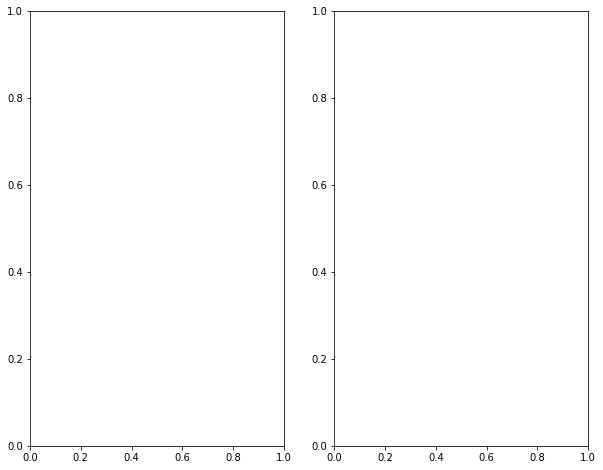

In [0]:
color = {False:'red', True:'green'}
Bad=df[df['labels']==False]
Good=df[df['labels']==True]
#fraudlist = creditData[creditData.Class == 1]
#normal = creditData[creditData.Class == 0]
fig,axes = plt.subplots(1,2)
axes[0].scatter(list(range(1,Bad.shape[0] + 1)), X_train, color='red')
axes[1].scatter(list(range(1, Good.shape[0] + 1)),X_test, color='green')
plt.show()

In [0]:
array_good=np.array(X_trainCol)
array_bad = np.array(X_testCol)

mean_good=np.mean(array_good, axis=1)
mean_bad=np.mean(array_bad, axis=1)

std_good=np.std(array_good, axis=1)
std_bad = np.std(array_bad, axis=1)

print(mean_good.shape)
print(std_good.shape)
print(mean_good)
print(std_good)


#bin =[]

#for i in range(1,101):
#    bin.append(i)

#print(bin)    
#np.reshape(bin, (100,1))
#print(bin.shape)
bin=np.arange(1,101)
bin.shape

#np.reshape(bin, (100,1))
#plt.plot(bin,mean_good)
plt.figure(1)
plt.errorbar(bin, mean_good, yerr=std_good, ecolor = 'green', label='both limits (default)')
plt.figure(2)
plt.errorbar(bin, mean_bad, yerr=std_bad, ecolor = 'red', label='both limits (default)')
plt.figure(3)
plt.errorbar(bin, mean_good, yerr=std_good, ecolor = 'green', label='both limits (default)')
plt.errorbar(bin, mean_bad, yerr=std_bad, ecolor = 'red', label='both limits (default)')
plt.show()
plt.figure(4)
plt.plot(bin, mean_good, color = 'green')
plt.plot(bin, mean_bad, color = 'red')
plt.figure(5)
plt.plot(bin, std_good, color = 'green')
plt.plot(bin, std_bad, color = 'red')
plt.show()


In [0]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean


input_size=len(X_train[0])
print(input_size)
input_layer = Input(shape=(input_size, ))
encoded = Dense(10, activation='tanh')(input_layer)
encoded1 = Dense(3, activation='tanh')(encoded)
encoded2 = Dense(10, activation='tanh')(encoded1)
decoder = Dense(input_size, activation='tanh')(encoded2)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder.layers):
             layer.name = 'layer_' + str(i)

autoencoder.summary()

In [0]:
history = autoencoder.fit(X_train,X_train, epochs=100, batch_size=500, shuffle=False, verbose=1,validation_split=0.1)

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history['loss'], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history['val_loss'], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    #plt.ylim(8258339,8258400)
    plt.yscale("log")
    plt.xlim(0,100)
    plt.show();

plot_loss(history, "Original model loss")

In [0]:
#LSTM
from numpy import array
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers.advanced_activations import ReLU

# define input sequence
X_train_lstm=normalize(X_trainS, norm='l1', axis=1)
X_test_lstm=normalize(X_testS, norm='l1', axis=1)
                      
df['lstm']=''
df['lstm'].loc[df['labels']==True]=X_train_lstm.tolist()
df['lstm'].loc[df['labels']==False]=X_test_lstm.tolist()

#sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#print(sequence.shape)
#n_in_seq = len(sequence)
#print(n_in_seq)
#sequence = sequence.reshape((1, n_in_seq, 1))
#print(sequence.shape)

# reshape input into [samples, timesteps, features]
n_in = len(X_train_lstm[0])
print(n_in)
print(X_train_lstm.shape)
X_train_lstm = X_train_lstm.reshape((202299, n_in, 1))
print(X_train_lstm.shape)
# define model
n_in = len(X_train_lstm[0])
model = Sequential()
model.add(LSTM(10, activation='tanh', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(10, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
for i, layer in enumerate(model.layers):
             layer.name = 'layer_' + str(i)

model.summary()
#history_lstm = model.fit(X_train_lstm,X_train_lstm, epochs=60, batch_size=500, shuffle=False, verbose=1,validation_split=0.1)
# fit model
#model.fit(sequence, sequence, epochs=300, verbose=0)
#plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history['loss'], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history['val_loss'], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    #plt.ylim(8258339,8258400)
    plt.yscale("log")
    plt.xlim(0,60)
    plt.show();

plot_loss(history_lstm, "Original model loss for LSTM")

In [0]:
predictionTest=autoencoder.predict(X_test)
predictionTrain=autoencoder.predict(X_train)

mseTest=K.eval(mseTop10(X_test, predictionTest))
mseTrain=K.eval(mseTop10(X_train, predictionTrain))

df['prediction']=""
df['mse']=""

df['prediction'].loc[df['labels']==True]=predictionTrain.tolist()
df['prediction'].loc[df['labels']==False]=predictionTest.tolist()

df['mse'].loc[df['labels']==True]=mseTrain
df['mse'].loc[df['labels']==False]=mseTest

print(df.head())
#print(df_test.head())


In [0]:
def globalMSETrend(df,type=1):
    
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in df['fromrun'].unique():
        if (type==1): val=(df['mse'][run]).mean()
        if (type==2): val=(df['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="blue", label="Run average: " + str(gmean))
    plt.hlines(gmean+(1.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='1 SD (' + str(gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.ylim(rmin*0.9,rmax*1.1)
    plt.scatter(df['fromrun'].unique(), y, marker='+', label='Data points')
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend()
    plt.show()

In [0]:
globalMSETrend(df[df.labels==True])

In [0]:
def CheckPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    mse=df_test['mse'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Reco MSE=" + str(mse))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

In [0]:
for run in df['fromrun'].unique():
    count=0
    for ls in df['fromlumi'][run]: 
        if df['labels'][run][ls]== False: continue
        if (count >2): continue
        count=count+1
        #CheckPredictions(df[df.train==True], run,ls)
        CheckPredictions(df[df['labels']==True], run,ls)

In [0]:
import pandas as pd
import numpy as np
#X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0)
#no need to normalize, we already have the normalized histogram in the df
print(X_trainA)

In [0]:
input_size=len(X_train[0])
input_layerA = Input(shape=(input_size, ))

encodedA = Dense(20, activation='sigmoid')(input_layerA)
encoded1A = Dense(10, activation='tanh')(encodedA)
encoded2A = Dense(20, activation='sigmoid')(encoded1A)
decoderA = Dense(input_size, activation='sigmoid')(encoded2A)

autoencoder_Opt = Model(inputs=input_layerA, outputs=decoderA)
autoencoder_Opt.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder_Opt.layers):
             layer.name = 'layer_' + str(i)

autoencoder_Opt.summary()

In [0]:
history_Opt = autoencoder_Opt.fit(X_trainA,X_trainA, epochs=300, batch_size=100, shuffle=True, verbose=1,validation_split=0.1)

In [0]:
#calculate predictions and mse and add to original DF

originS=np.stack(df['origin'].values, axis=0)
predictionA=autoencoder_Opt.predict(originS)

mseA=K.eval(mseTop10(originS,predictionA))

df['predictions2']=""
df['mse2']=""

df['prediction2']=predictionA.tolist()
df['mse2']=mseA


print(df.head())

In [0]:
def CheckAllPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    ahisto2=df_test['prediction2'][run][ls]
    mse=df_test['mse'][run][ls]
    mse2=df_test['mse2'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Raw Reco, mse:" + str(mse))
    plt.step(x, ahisto2, where='mid', label=" Reco, mse:" + str(mse2))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

In [0]:
#compare some old and new predictions

for run in df['fromrun'].unique():
    count=0
    if run <298000: continue
    for ls in df['fromlumi'][run]: 
        if df['train'][run][ls]== True: continue
        if df['mse2'][run][ls]<0.00001: continue
        if df['entries'][run][ls]<3000: continue
        #if (count >2): continue
        count=count+1
        #print(df.entries)[run][ls]
        CheckAllPredictions(df[df.train==False], run,ls)